# World happiness survey analysis

Import the modules useful for the analysis.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
%matplotlib inline

Load the data set of interest. For more information, see https://en.wikipedia.org/wiki/World_Happiness_Report. We will use the 2015 data as training set, the 2016 as test set, hence the 2016 data is not loaded yet.

In [2]:
data_2015 = pd.read_csv('Data/world_happiness_2015.csv')

Getting some high-level statistical information on the data set.

In [3]:
data_2015

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176
5,Finland,Western Europe,6,7.406,0.03140,1.29025,1.31826,0.88911,0.64169,0.41372,0.23351,2.61955
6,Netherlands,Western Europe,7,7.378,0.02799,1.32944,1.28017,0.89284,0.61576,0.31814,0.47610,2.46570
7,Sweden,Western Europe,8,7.364,0.03157,1.33171,1.28907,0.91087,0.65980,0.43844,0.36262,2.37119
8,New Zealand,Australia and New Zealand,9,7.286,0.03371,1.25018,1.31967,0.90837,0.63938,0.42922,0.47501,2.26425
9,Australia,Australia and New Zealand,10,7.284,0.04083,1.33358,1.30923,0.93156,0.65124,0.35637,0.43562,2.26646


In [4]:
data_2015.describe()

,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,79.493671,5.375734,0.047885,0.846137,0.991046,0.630259,0.428615,0.143422,0.237296,2.098977
std,45.754363,1.145010,0.017146,0.403121,0.272369,0.247078,0.150693,0.120034,0.126685,0.553550
min,1.000000,2.839000,0.018480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580
25%,40.250000,4.526000,0.037268,0.545808,0.856823,0.439185,0.328330,0.061675,0.150553,1.759410
50%,79.500000,5.232500,0.043940,0.910245,1.029510,0.696705,0.435515,0.107220,0.216130,2.095415
75%,118.750000,6.243750,0.052300,1.158448,1.214405,0.811013,0.549092,0.180255,0.309883,2.462415
max,158.000000,7.587000,0.136930,1.690420,1.402230,1.025250,0.669730,0.551910,0.795880,3.602140


In [5]:
data_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
Country                          158 non-null object
Region                           158 non-null object
Happiness Rank                   158 non-null int64
Happiness Score                  158 non-null float64
Standard Error                   158 non-null float64
Economy (GDP per Capita)         158 non-null float64
Family                           158 non-null float64
Health (Life Expectancy)         158 non-null float64
Freedom                          158 non-null float64
Trust (Government Corruption)    158 non-null float64
Generosity                       158 non-null float64
Dystopia Residual                158 non-null float64
dtypes: float64(9), int64(1), object(2)
memory usage: 14.9+ KB


There doesn't seem to be any missing data, so an imputer is not required.

## Data preparation

Define a data selector.

In [6]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attr_names):
        self.attribute_names = attr_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Pipeline to transform `Region` attribute to one-hot attributes.

In [7]:
region_pipeline = Pipeline([
    ('region_selector', DataFrameSelector(['Region'])),
    ('binarizer', LabelBinarizer()),
])

Pipeline to select and scale numerical attributes.

In [8]:
num_attr_names = ['Economy (GDP per Capita)', 'Family',
                  'Health (Life Expectancy)', 'Freedom',
                  'Trust (Government Corruption)', 'Generosity',
                  'Dystopia Residual']

In [9]:
num_attrs_pipeline = Pipeline([
    ('num_attrs_selector', DataFrameSelector(num_attr_names)),
    ('scaling', MinMaxScaler()),
])

In [11]:
preparation_pipeline = FeatureUnion(transformer_list=[
    ('region_attr', region_pipeline),
    ('num_attrs', num_attrs_pipeline),
])

In [14]:
prepared_data = preparation_pipeline.fit_transform(data_2015)

In [18]:
region_names = region_pipeline.classes_.tolist()

In [27]:
prepared_df = pd.DataFrame(prepared_data, columns=region_names + num_attr_names)

## Some trends

Given the limited number of factors, we can visualize potential correllations using a scatter matrix.

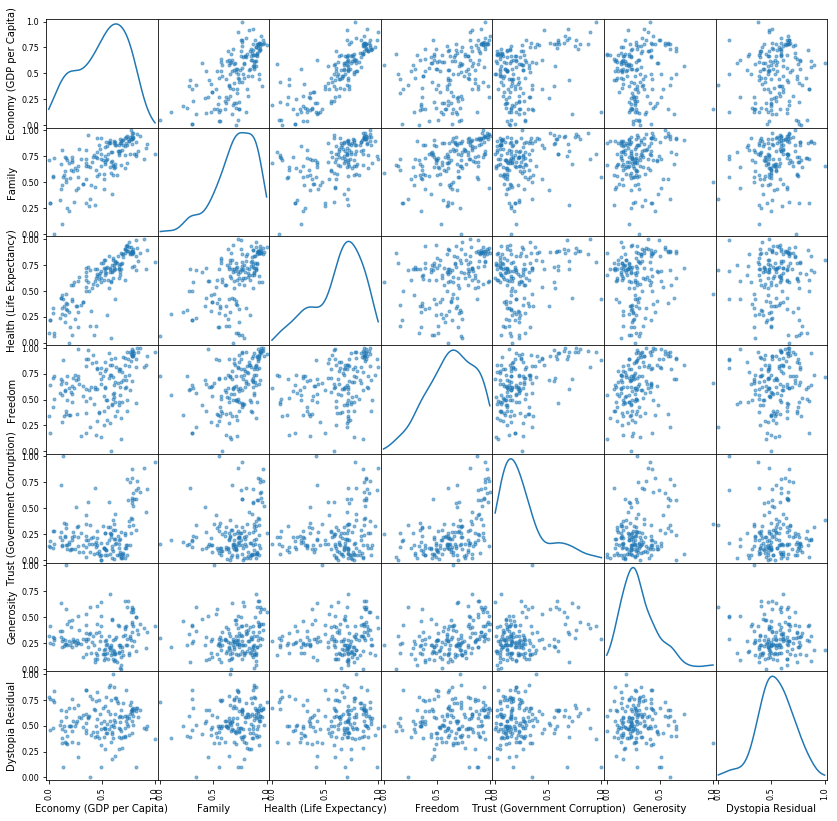

In [28]:
scatter_matrix(prepared_df[num_attr_names], figsize=(14, 14), diagonal='kde');

## Analysis

We will perform a PCA, and want 95 % of the variation explained by the principal components.

In [29]:
pca = PCA(n_components=0.95).fit(prepared_df[num_attr_names])

In [30]:
pd.DataFrame(data=pca.components_, columns=num_attr_names,
             index=(f'factor {i}' for i in range(1, len(pca.components_) + 1)))

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
factor 1,-0.555693,-0.377036,-0.541984,-0.394331,-0.300629,-0.092451,-0.029680
factor 2,-0.335765,-0.127760,-0.335113,0.528774,0.587147,0.360414,-0.066313
factor 3,0.125246,-0.358359,0.229306,-0.326153,0.288593,0.067628,-0.780433
factor 4,-0.140025,0.161327,0.080067,0.351787,-0.652519,0.470704,-0.420545
factor 5,0.088450,0.517259,-0.464458,0.146912,0.040130,-0.530225,-0.452290
factor 6,0.012856,-0.571232,0.177549,0.558288,-0.189897,-0.541394,-0.033922


Somewhat surprisingly, six components are required to explain 95 % of the variation in the data.  Note that this does not take into account the categorical data, i.e., the region.

In [31]:
pca_df = pd.DataFrame(data=pca.transform(prepared_df[num_attr_names]),
                      columns=(f'factor {i}' for i in range(1, len(pca.components_) + 1)))

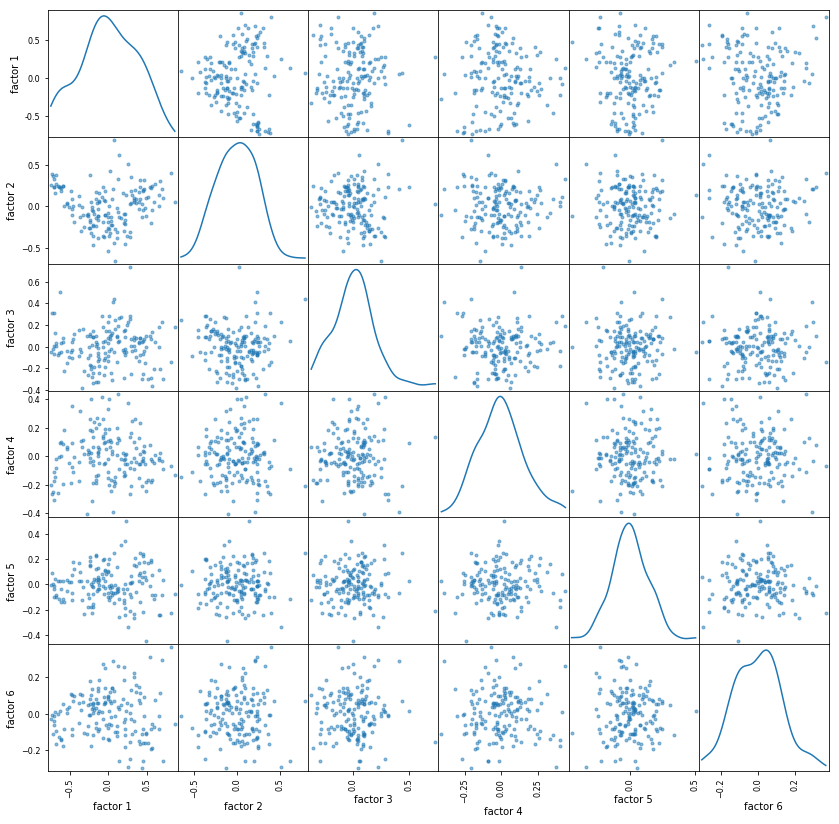

In [33]:
scatter_matrix(pca_df, figsize=(14, 14), diagonal='kde');

There is no obvious correlation visible in the transformed factors, which is indeed expected from the dimensionality reduction.  Given that we can only reduce to six, rather than seven dimensions, we keep working with the original (rescaled) attributes.

## Modelling & training

Try some algorithms, fitting to the 2015 data set happiness score.

In [34]:
X = np.array(prepared_data)
Y = np.array(data_2015['Happiness Score'])

### Ridge regression

In [35]:
rr = Ridge(alpha=0.5, fit_intercept=False)

In [36]:
rr.fit(X, Y);

In [37]:
rr.score(X, Y)

0.99842950038451161

In [38]:
rr_scores = cross_val_score(rr, X, Y, scoring='neg_mean_squared_error', cv=10)

Check the scores.

In [39]:
rmse_rr_scores = np.sqrt(-rr_scores)

In [40]:
rmse_rr_scores

array([ 0.19535703,  0.0215212 ,  0.05791113,  0.04777635,  0.05505139,
        0.06492417,  0.05910043,  0.04511534,  0.07294399,  0.08033956])

In [41]:
print(rmse_rr_scores.mean(), rmse_rr_scores.std())

0.0700040601678 0.0445055682464


In [42]:
Y_rr = rr.predict(X)

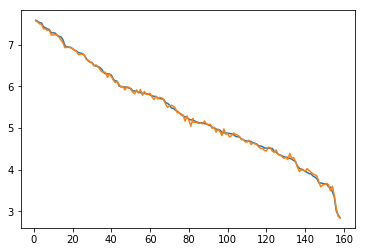

In [43]:
plt.plot(data_2015['Happiness Rank'], Y)
plt.plot(data_2015['Happiness Rank'], Y_rr);

### Random forest

In [44]:
rf = RandomForestRegressor()

In [45]:
rf.fit(X, Y);

In [46]:
Y_rf = rf.predict(X)

In [47]:
rf.score(X, Y)

0.9801388670371094

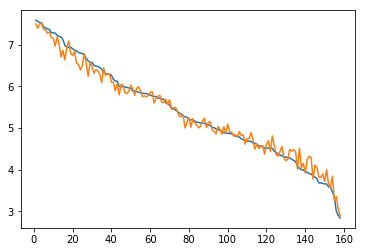

In [48]:
plt.plot(data_2015['Happiness Rank'], Y)
plt.plot(data_2015['Happiness Rank'], Y_rf);

In [49]:
rf_scores = cross_val_score(rf, X, Y, scoring='neg_mean_squared_error', cv=10)

In [50]:
rmse_rf_scores = np.sqrt(-rf_scores)

In [51]:
rmse_rf_scores

array([ 0.66917493,  0.44041205,  0.35298566,  0.13194374,  0.33087509,
        0.30789798,  0.31891482,  0.28435726,  0.43343769,  0.88940075])

In [52]:
print(rmse_rf_scores.mean(), rmse_rf_scores.std())

0.415939996238 0.204805323458


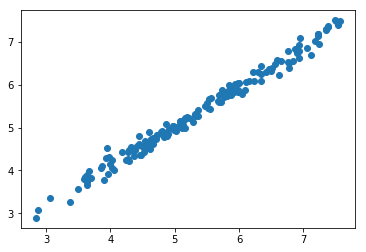

In [53]:
plt.plot(Y_rr, Y_rf, 'o');

## Test data

In [54]:
data_2016 = pd.read_csv('Data/world_happiness_2016.csv')

In [55]:
prepared_test_data = preparation_pipeline.fit_transform(data_2016)

In [56]:
X_test = np.array(prepared_test_data)
Y_test = np.array(data_2016['Happiness Score'])

In [57]:
Y_test_rr = rr.predict(X_test)

In [58]:
rr.score(X_test, Y_test)

0.95881196269179347

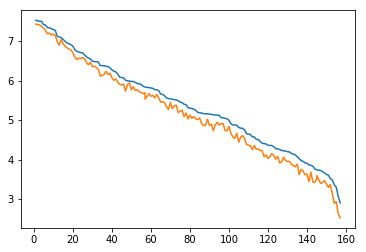

In [59]:
plt.plot(data_2016['Happiness Rank'], Y_test)
plt.plot(data_2016['Happiness Rank'], Y_test_rr);

In [60]:
Y_test_rf = rf.predict(X_test)

In [61]:
rf.score(X_test, Y_test)

0.93029478340636462

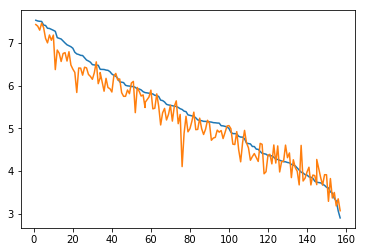

In [62]:
plt.plot(data_2016['Happiness Rank'], Y_test)
plt.plot(data_2016['Happiness Rank'], Y_test_rf);